# [E-06] Movie Review

> 목차
-


**1. 개요**  
    
    1.1 프로젝트 과정 및 목표  

**2. 루브릭 평가기준**  

**3. Project**
    
    3.1 데이터 준비
    3.2 데이터 로더 구성
    3.3 모델 구성을 위한 데이터 분석 및 가공
    3.4 모델 구성 및 Validation Set 구성
    3.5 모델 훈련 개시
    3.6 Loss, Accuracy 그래프 시각화
    3.7 학습된 Embedding 레이어 분석
    3.8 한국어 Word2Vec 임베딩 활용하여 성능 개선
    3.9 다른 모델을 이용해 훈련


**4. 회고**
    
    4.1 결과 평가  
    4.2 어려웠던 점
    

---
> **1. 개요**
-

> **1.1 프로젝트 과정 및 목표**

학습을 시켜서 연관된 단어가 나오도록 만드는게 프로젝트 목표이다.  

프로젝트 과정은  
1. 데이터 준비
2. 데이터 로더 구성
3. 모델 구성을 위한 데이터 분석 및 가공
4. 모델 구성 및 Validation Set 구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석
8. 한국어 Word2Vec 임베딩 활용하여 성능 개선




---
> **2. 루브릭 평가기준**
-

|평가문항 | 상세기준|
|:---------|:---------|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. | 3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. | gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.| 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

---
> **3. Project**
-

> 3.1 데이터 준비하기

In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import os
import matplotlib as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(len(train_data))

150000


In [3]:
print(train_data.isnull().values.any())

True


In [4]:
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')
# Null 값이 존재하는지 확인
print(train_data.isnull().values.any()) 

False


In [5]:
print(len(train_data))

149995


> 3.2 데이터로더 구성

In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [7]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

> 3.3 모델 구성을 위한 데이터 분석 및 가공

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


> 3.4 모델 구성 및 Validation set 구성

In [12]:
# validation set 50000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 96182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


> 3.5 모델 훈련 개시

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 5s 7ms/step - loss: 0.5562 - accuracy: 0.6945 - val_loss: 0.3747 - val_accuracy: 0.8402
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3481 - accuracy: 0.8532 - val_loss: 0.3469 - val_accuracy: 0.8488
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3211 - accuracy: 0.8651 - val_loss: 0.3500 - val_accuracy: 0.8493
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3105 - accuracy: 0.8699 - val_loss: 0.3621 - val_accuracy: 0.8433
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3036 - accuracy: 0.8731 - val_loss: 0.3534 - val_accuracy: 0.8487
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.8759 - val_loss: 0.3541 - val_accuracy: 0.8505
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2899 - accuracy: 0.8786 - val_loss: 0.3533 - val_accuracy: 0.8485
Epoch 

In [14]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4765 - accuracy: 0.8350
[0.47653308510780334, 0.8349980711936951]


In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


> 3.6 Loss, Accuracy 그래프 시각화

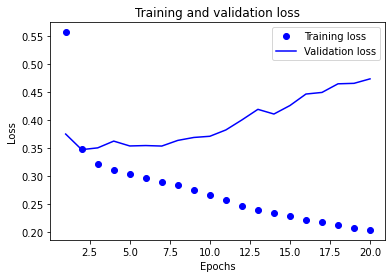

In [16]:
from matplotlib import pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

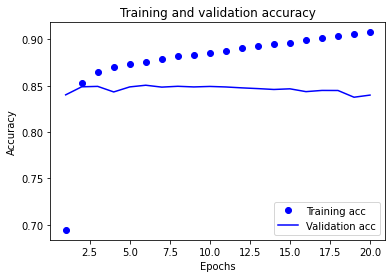

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> 3.7 학습된 Embedding 레이어 분석

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


> 3.8 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [19]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-6, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(6,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사람']
vector

array([ 0.14694506,  0.10710593,  0.16412349, -0.1444246 , -0.12486319,
       -0.13565116, -0.10851303, -0.11117005,  0.1975856 ,  0.21322756,
       -0.12070678, -0.00439194, -0.07389111,  0.03491838, -0.09016784,
        0.04366561], dtype=float32)

In [21]:
word_vectors.similar_by_word("마동석")

[('꼬마', 0.9273446202278137),
 ('역', 0.9028814435005188),
 ('프레임', 0.899718165397644),
 ('후유증', 0.8974853754043579),
 ('서유기', 0.8960239291191101),
 ('어처구니', 0.8943296074867249),
 ('~~~!!!', 0.8913761377334595),
 ('엽기', 0.891185998916626),
 ('나가', 0.8855347037315369),
 ('파괴', 0.8764195442199707)]

In [22]:
word_vectors.similar_by_word("어벤져스")

[('봅니다', 0.9073124527931213),
 ('토미', 0.8886330127716064),
 ('홍콩', 0.8822334408760071),
 ('정체', 0.8821280598640442),
 ('대세', 0.8791905641555786),
 ('최민식', 0.8756670355796814),
 ('ㅡ', 0.8738470077514648),
 ('경고', 0.8718730211257935),
 ('두근두근', 0.8591446876525879),
 ('쓰래', 0.8581293225288391)]

In [23]:
word_vectors.similar_by_word("좀비")

[('조미료', 0.9623663425445557),
 ('도데체', 0.96131432056427),
 ('사위', 0.9579158425331116),
 ('행성', 0.9557459354400635),
 ('컨대', 0.9554974436759949),
 ('처한', 0.955390214920044),
 ('막힌', 0.9551834464073181),
 ('주름', 0.953252375125885),
 ('찰', 0.9529784917831421),
 ('느그', 0.9520553350448608)]

> 3.9 다른 모델을 이용해서 훈련

## 1-D Convolution Neural Network(1-D CNN)

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [25]:
# validation set 50000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 96182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)


Epoch 1/20
227/227 [==============================] - 3s 6ms/step - loss: 0.5484 - accuracy: 0.7018 - val_loss: 0.3714 - val_accuracy: 0.8373
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3417 - accuracy: 0.8554 - val_loss: 0.3490 - val_accuracy: 0.8481
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3101 - accuracy: 0.8708 - val_loss: 0.3417 - val_accuracy: 0.8533
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2902 - accuracy: 0.8810 - val_loss: 0.3436 - val_accuracy: 0.8533
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2718 - accuracy: 0.8904 - val_loss: 0.3436 - val_accuracy: 0.8533
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2486 - accuracy: 0.9018 - val_loss: 0.3522 - val_accuracy: 0.8518
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2222 - accuracy: 0.9147 - val_loss: 0.3698 - val_accuracy: 0.8496
Epoch 

In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-6, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(6,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사람']

In [28]:
word_vectors.similar_by_word("마동석")

[('네임', 0.8954653739929199),
 ('구조', 0.8816702961921692),
 ('낌', 0.8582437634468079),
 ('찜찜', 0.8548423647880554),
 ('붕', 0.8398119807243347),
 ('바이올린', 0.830985426902771),
 ('넘쳤', 0.8243061900138855),
 ('단조', 0.8191036581993103),
 ('향수', 0.8170067071914673),
 ('흔들리', 0.8102595210075378)]

In [29]:
word_vectors.similar_by_word("어벤져스")

[('쩝', 0.8340057134628296),
 ('댓', 0.8147746324539185),
 ('여사', 0.8127694725990295),
 ('할게요', 0.8069168329238892),
 ('날라', 0.8037672638893127),
 ('떤', 0.7970177531242371),
 ('지치', 0.7870643734931946),
 ('에디', 0.7844506502151489),
 ('스타크래프트', 0.7827093601226807),
 ('끝나', 0.7788771986961365)]

In [30]:
word_vectors.similar_by_word("좀비")

[('혼합', 0.8611419796943665),
 ('비주얼', 0.8217021822929382),
 ('한결', 0.8167331218719482),
 ('비하', 0.8031924962997437),
 ('............', 0.7754606604576111),
 ('태극기', 0.7724000215530396),
 ('훼손', 0.7688872218132019),
 ('상영관', 0.7631894946098328),
 ('포장', 0.7607177495956421),
 ('사실감', 0.756860613822937)]

## GlobalMaxPooling1D()

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [32]:
# validation set 50000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 96182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.5889 - accuracy: 0.7259 - val_loss: 0.4300 - val_accuracy: 0.8201
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3795 - accuracy: 0.8380 - val_loss: 0.3614 - val_accuracy: 0.8391
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3286 - accuracy: 0.8613 - val_loss: 0.3503 - val_accuracy: 0.8451
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3007 - accuracy: 0.8740 - val_loss: 0.3507 - val_accuracy: 0.8456
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2803 - accuracy: 0.8842 - val_loss: 0.3549 - val_accuracy: 0.8461
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2635 - accuracy: 0.8917 - val_loss: 0.3615 - val_accuracy: 0.8452
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2491 - accuracy: 0.8987 - val_loss: 0.3699 - val_accuracy: 0.8453
Epoch 

In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-6, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(6,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사람']

In [35]:
word_vectors.similar_by_word("마동석")

[('The', 0.8966276049613953),
 ('블러드', 0.8852807283401489),
 ('우울증', 0.853748619556427),
 ('냈', 0.8481966257095337),
 ('할머니', 0.8365134000778198),
 ('양반', 0.828490138053894),
 ('트립', 0.8232161998748779),
 ('박철민', 0.8195591568946838),
 ('제한', 0.819327175617218),
 ('조건', 0.818117082118988)]

In [36]:
word_vectors.similar_by_word("어벤져스")

[('드물', 0.8932904601097107),
 ('불친절', 0.8609111905097961),
 ('곰', 0.856590747833252),
 ('평이', 0.8372223377227783),
 ('총질', 0.833018958568573),
 ('사다코', 0.8299461007118225),
 ('공평', 0.8293358683586121),
 ('완성도', 0.8215513825416565),
 ('이럴', 0.8163357973098755),
 ('공략', 0.8146414756774902)]

In [37]:
word_vectors.similar_by_word("좀비")

[('촬영', 0.8339600563049316),
 ('설', 0.8177927136421204),
 ('린치', 0.8058621883392334),
 ('드만', 0.7809708714485168),
 ('빛나', 0.7769008874893188),
 ('완결', 0.7729660272598267),
 ('작년', 0.7666745185852051),
 ('빨려', 0.7605525851249695),
 ('할려고', 0.7588196396827698),
 ('싸구려', 0.7456527352333069)]

> **4. 회고**
-

> 4.1 결과 평가

**<1차시도>**
조건  
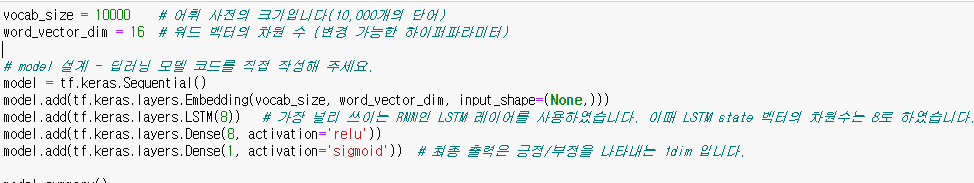
+ Validation set 10000건 분리  
+ Epochs : 20회  
+ optimizor : LSTM  



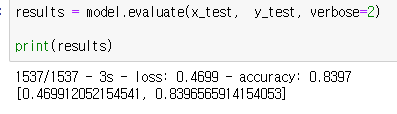
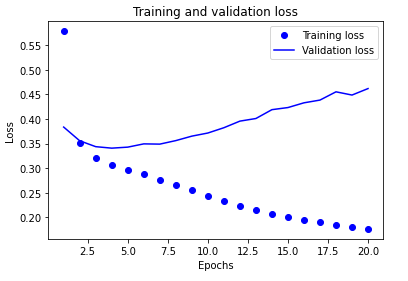
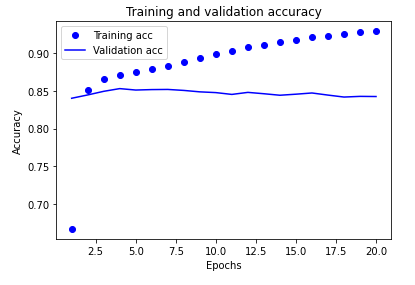

**<3차시도>**
조건  
+ Validation set 30000건 분리  
+ Epochs : 5회  
+ optimizor : LSTM 

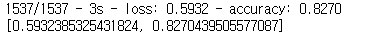

에폭을 줄이면 정확도가 어떻게 변할지 궁금해서 시도했는데 정확도가 떨어져서 다시 에폭을 원래대로 20으로 해야겠다고 생각이 들었습니다.



> 4.2 어려웠던 점

정확도가 많이나와서 기대하면서 연관 단어를 뽑았는데 생각보다 잘안맞아서 정확도를 더 높여야 된다는 생각에 고민을 많이 했다.  
한국어 Word2Vec 임베딩 활용하여 성능 개선을 하는 방법을 찾아봤는데, 어떻게 해도 계속 에러가 나와서 결국은 못했다...  
파일을 불러오는 과정에서 에러가 생긴 경우인데 이런 측면에서 공부가 덜 되서 그런거라 생각되고 앞으로 더 공부를 많이해야겠다는 다짐을 하게되었습니다. 
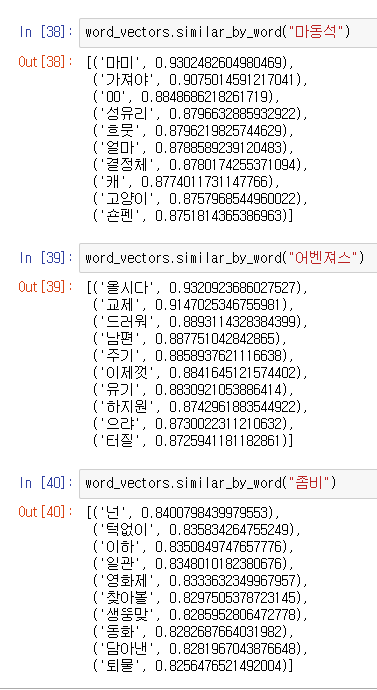